# TESTING: Ranking Annual Temperatures in Space

**Goal:** Create the data needed to recreate the map from: http://berkeleyearth.org/global-temperature-report-for-2021/ that displays cells on the Earth where it was the 1st, 2nd, or 3rd warmest/coldest year.

To do this we will need annual averages, then a way to rank them. Once ranked we can pull the rankings that 2021 had, then mask values at top 3 or bottom 3. Then it just needs to be colored appropriately.

**Products Created:**
 - Annual average temps (full years) saved as a netcdf
 - Temperature rankings saved as a netcdf

In [1]:
# Libraries
import os
import xarray as xr
import datetime
import oisstools as ot
import warnings
import bottleneck



#### 1. Set workspace
workspace = "local"
box_root = ot.set_workspace("local")
_cache_root = ot.set_cache_root(box_root)

# What year are we pulling out to plot
start_yr = 1982
comparison_yr = 2021

#### 3. Print Last Update
print(f"Working via directory at:             {box_root}")
print(f"Years are ranked in temperature from: {start_yr}-{comparison_yr}")

Working via directory at:             /Users/akemberling/Library/CloudStorage/Box-Box/
Years are ranked in temperature from: 1982-2021


## Load OISST Temperatures for Complete Years

In [2]:
# Load all the complete years
temps = ot.load_box_oisst(box_root, 
                          start_yr = start_yr, 
                          end_yr = comparison_yr, 
                          anomalies = False, 
                          do_parallel = False)
anoms = ot.load_box_oisst(box_root, 
                          start_yr = start_yr, 
                          end_yr = comparison_yr, 
                          anomalies = True, 
                          do_parallel = False)
temps

<xarray.Dataset>
Dimensions:  (time: 14610, lat: 720, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 1982-01-01 1982-01-02 ... 2021-12-31
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
Data variables:
    sst      (time, lat, lon) float32 dask.array<chunksize=(365, 720, 1440), meta=np.ndarray>
Attributes:
    Conventions:    CF-1.5
    title:          NOAA High-resolution Blended Analysis: Daily Values using...
    institution:    NOAA/NCDC
    source:         NOAA/NCDC  ftp://eclipse.ncdc.noaa.gov/pub/OI-daily-v2/
    comment:        Reynolds, et al., 2007: Daily High-Resolution-Blended Ana...
    history:        Thu Aug 24 13:35:47 2017: ncatted -O -a References,global...
    references:     https://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oiss...
    dataset_title:  NOAA Daily Optimum Interpolation Sea Surface Temperature

In [3]:
# Get yearly averages
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    temps_yrs = temps.groupby('time.year').mean()#.load()
    anoms_yrs = anoms.groupby('time.year').mean()#.load()
anoms_yrs

<xarray.Dataset>
Dimensions:  (lon: 1440, lat: 720, year: 40)
Coordinates:
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * year     (year) int64 1982 1983 1984 1985 1986 ... 2017 2018 2019 2020 2021
Data variables:
    sst      (year, lat, lon) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>

In [4]:
# Combine to same Dataset
years_tidy = xr.merge([temps_yrs, anoms_yrs.rename({"sst": "sst_anom"})])
years_tidy

<xarray.Dataset>
Dimensions:   (lat: 720, lon: 1440, year: 40)
Coordinates:
  * lat       (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon       (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
  * year      (year) int64 1982 1983 1984 1985 1986 ... 2017 2018 2019 2020 2021
Data variables:
    sst       (year, lat, lon) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    sst_anom  (year, lat, lon) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>

In [6]:
# Save Yearly averages
temps_fname = f'{box_root}RES_Data/OISST/oisst_mainstays/yearly_averages/annual_sst_{start_yr}to{comparison_yr}.nc'
years_tidy.to_netcdf(temps_fname)
print(f"Saving Yearly Averages for: {start_yr} to {comparison_yr}")

Saving Yearly Averages for: 1982 to 2021


## Ranking Yearly Average Temperatures

In [7]:
# Rank the years
yr_ranks = temps_yrs.load().rank("year")

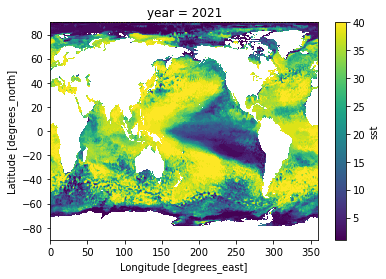

In [8]:
# Plot to see if it did what you thought
ranks_21 = yr_ranks.sst.sel(year = 2021)
ranks_21.plot()

# # How many ranks there are (40)
# comparison_yr - start_yr + 1

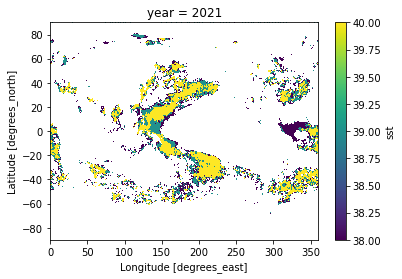

In [9]:
# Areas that experienced temps in top 3 warmest years
ranks_21.where(ranks_21 >= 38).plot()

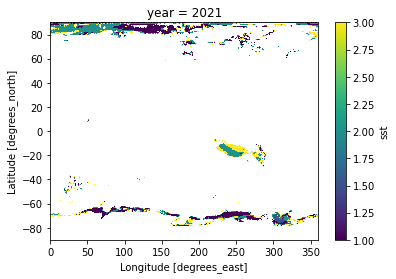

In [10]:
# Areas that experienced temps in bottom 3 warmest years
ranks_21.where(ranks_21 <= 3).plot()

In [11]:
# Save the yearly ranks
ranks_fname = f'{box_root}RES_Data/OISST/oisst_mainstays/temp_rankings/yrly_ranks_{start_yr}to{comparison_yr}.nc'
yr_ranks.to_netcdf(ranks_fname)
print(f"Saving Yearly Temperature Rankings for: {start_yr} to {comparison_yr}")

Saving Yearly Temperature Rankings for: 1982 to 2021
